<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/Copy_of_1D_Diffusion_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyDOE

cuda
Epoch: 100, MSE: 0.103831
Epoch: 200, MSE: 0.062920
Epoch: 300, MSE: 0.035880
Epoch: 400, MSE: 0.014081
Epoch: 500, MSE: 0.004343
Epoch: 600, MSE: 0.001982
Epoch: 700, MSE: 0.001188
Epoch: 800, MSE: 0.000838
Epoch: 900, MSE: 0.000661
Epoch: 1000, MSE: 0.000509
Total training time in minutes: 0.4204662005106608


<ipython-input-6-ac859186eb7d>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(path))
<ipython-input-6-ac859186eb7d>:121: FutureWarning: Yo

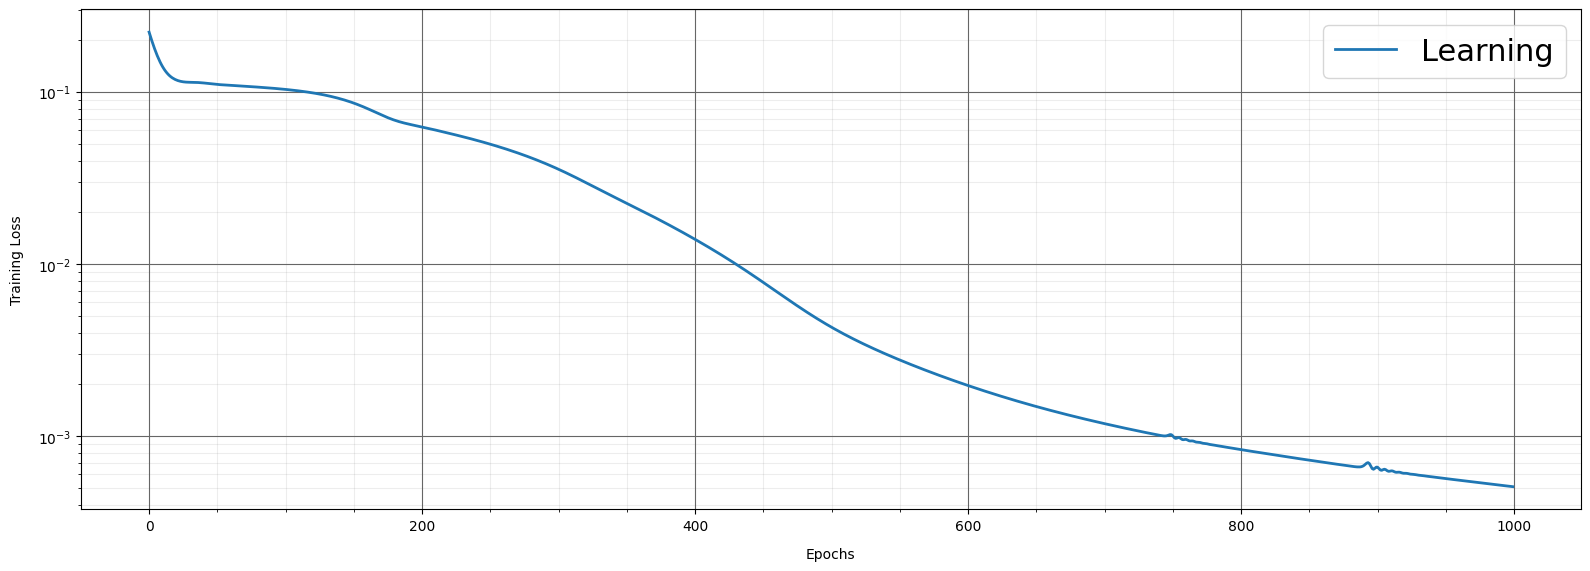

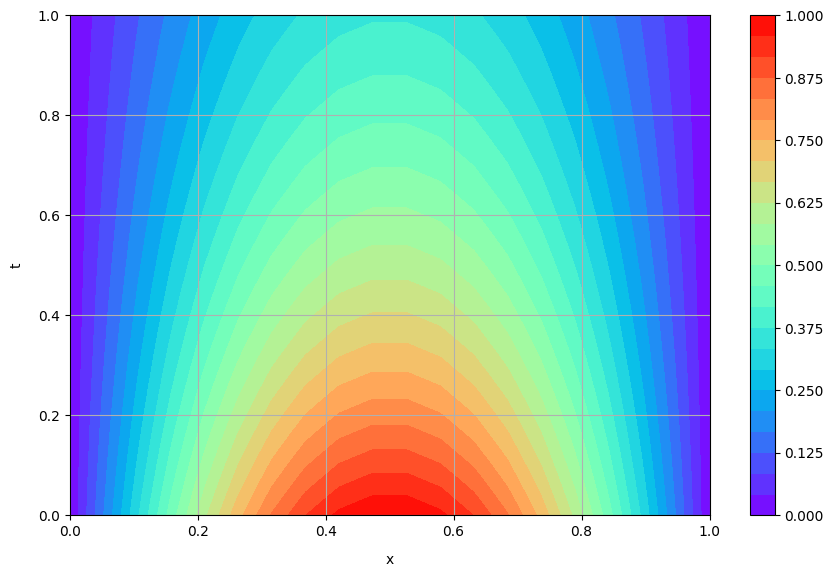

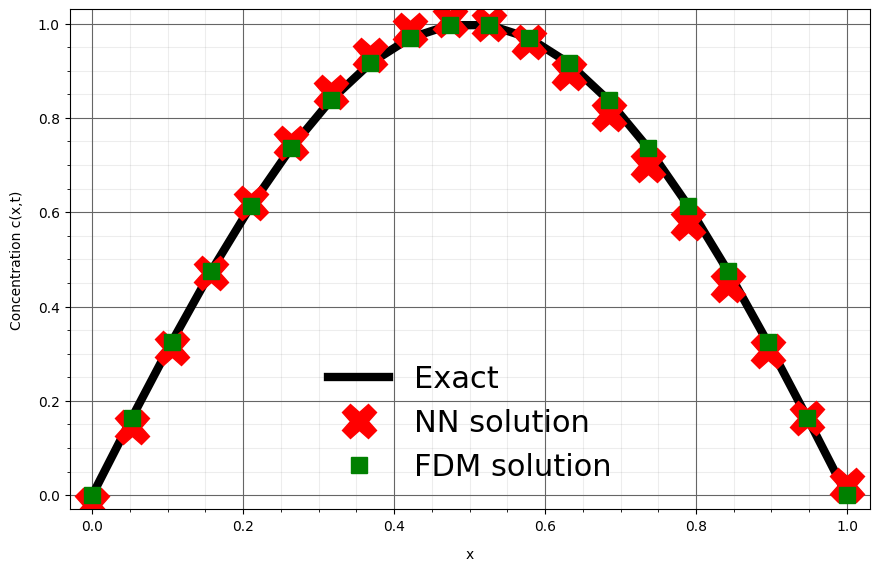

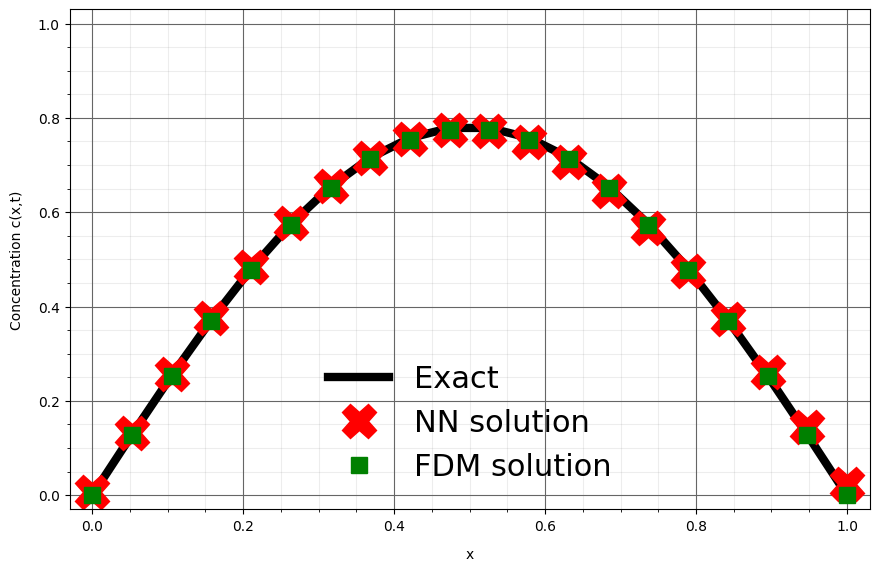

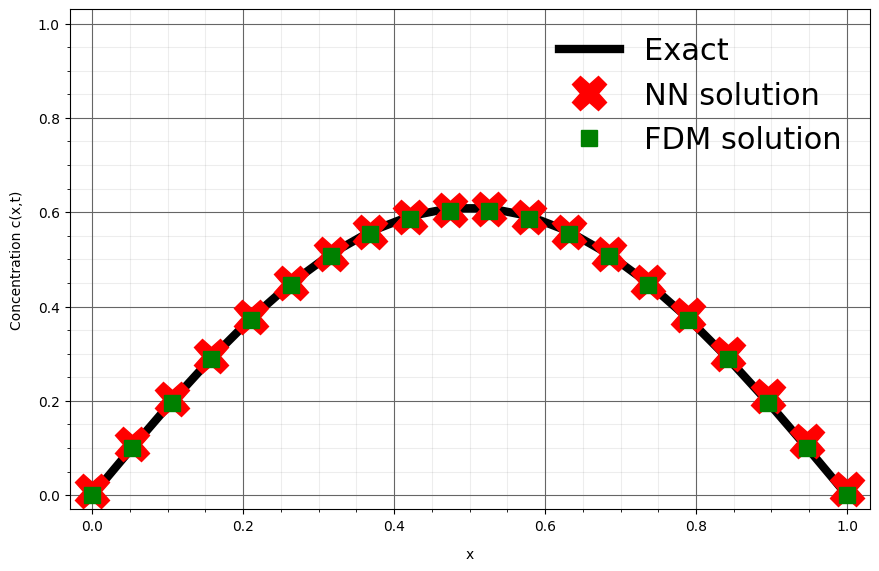

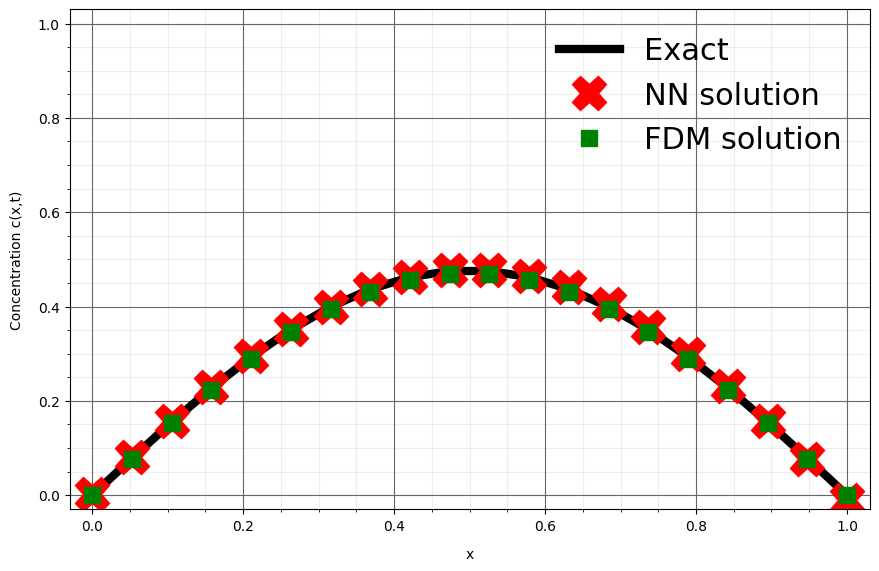

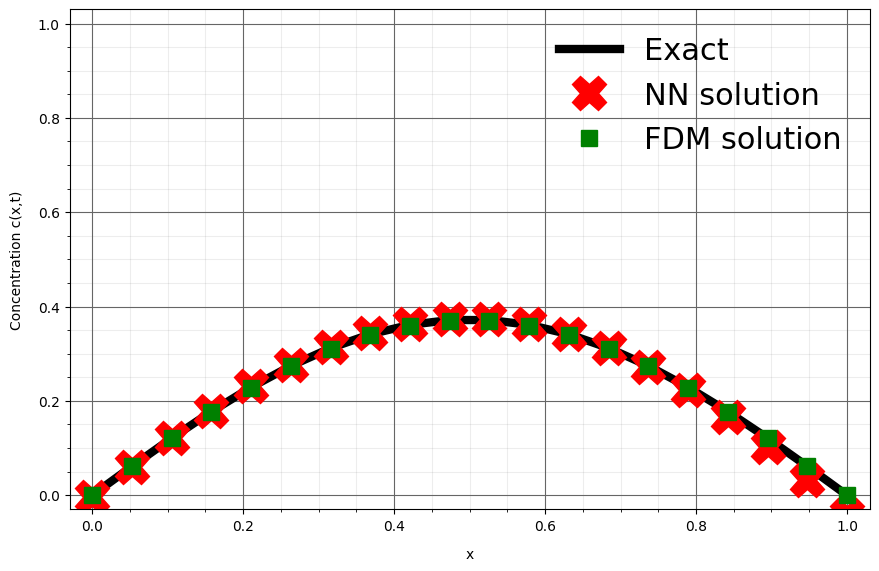

In [6]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import *
from scipy.integrate import odeint
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.__version__

torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(layers)-2):
            z = self.linears[i](x)
            x = self.activation(z)
        x = self.linears[-1](x)
        return x

    def loss_bc_init(self, x, y):
        loss_c = self.loss_function(self.forward(x), y)
        return loss_c

    def loss_internal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        p_grad = gradients(p, x_train)[0]
        c_x, c_t = p_grad[:, 0], p_grad[:, [1]]
        c_xx = gradients(c_x, x_train)[0][:, [0]]
        pde = c_t - D * c_xx
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x, y, x_to_train_f):
        loss_c = self.loss_bc_init(init_cond_train, u_init_cond_train)
        loss_f = self.loss_internal(f_train)
        loss_total = loss_c + loss_f
        return loss_total

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

def trainingdata(Nx, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)
    X, T = np.meshgrid(x, t)
    initial_condition = np.hstack((X[0, :][:, None], T[0, :][:, None]))
    c_initial = np.sin(np.pi * x).reshape(-1, 1)
    left_bc = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
    c_left_bc = np.zeros(len(t)).reshape(-1, 1)
    right_bc = np.hstack((X[:, -1][:, None], T[:, 0][:, None]))
    c_right_bc = np.zeros(len(t)).reshape(-1, 1)
    all_bcs = np.vstack([initial_condition, left_bc, right_bc])
    all_c_bcs = np.vstack([c_initial, c_left_bc, c_right_bc])
    idx = np.random.choice(all_bcs.shape[0], Nu, replace=False)
    all_bcs = all_bcs[idx, :]
    all_c_bcs = all_c_bcs[idx, :]
    f_train = lhs(2, Nf)
    f_train = np.vstack((f_train, all_bcs))
    return all_bcs, all_c_bcs, f_train

N_u = 300
N_x = 100
N_t = 100
N_f = 10000

init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)

D = 0.1

layers = np.array([2, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1])
mlp = MLP(layers).to(device)

step_size = 20000
gamma = 0.5
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
max_iter = 1000

tic = time.time()
for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
         print("Epoch: {}, MSE: {:.6f}".format((i+1), loss.item()))
toc = time.time()
print(f'Total training time in minutes: {(toc-tic)/60}')

path = '1D-SoluteDiffusion_PDE_trained.pth'
torch.save(mlp.state_dict(), path)

path = '/content/1D-SoluteDiffusion_PDE_trained.pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()

model = MLP(layers)
state_dict = torch.load('/content/1D-SoluteDiffusion_PDE_trained.pth')
model.load_state_dict(state_dict)
model.eval()
example = torch.rand(1, 2)
traced_script_module = torch.jit.trace(model, example)
torch.jit.save(traced_script_module, "SoluteDiffusion_PDE.pt")
loaded = torch.jit.load("SoluteDiffusion_PDE.pt")

A_hist = np.array(A_hist)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(visible=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
ax.plot(A_hist[:, 0], A_hist[:, 1], linewidth=2, label='Learning')
ax.legend(loc='best', frameon=True, fontsize=22)
ax.semilogy()
ax.set_xlabel('Epochs', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)
plt.savefig('Activation.png', dpi=300, transparent=False, bbox_inches='tight')

def central_difference(n, i, delta_x, delta_t, c):
    return c[n][i] + delta_t * (D * (c[n][i+1] - 2*c[n][i] + c[n][i-1])/(delta_x)**2)

points_in_x = 20
x = np.linspace(0, 1, points_in_x)
delta_x = x[1] - x[0]

delta_t = 0.5 * delta_x**2 / D
points_in_t = int(1.0/delta_t)
t = np.linspace(0, 1, points_in_t)
delta_t = t[1] - t[0]

c = np.zeros((len(t), len(x)))
c[:, 0] = 0
c[:, -1] = 0
c[0, 1:-1] = np.sin(np.pi*x[1:-1])

for n in range(0, len(t)-1):
    for i in range(1, len(x)-1):
        c[n+1][i] = central_difference(n, i, delta_x, delta_t, c)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
img = ax.contourf(x, t, c, levels=np.linspace(0, 1, 25), cmap='rainbow')
fig.colorbar(img)
ax.grid()
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('t', labelpad=10)
plt.savefig('1DSoluteDiffusion_FDM.png', dpi=300, transparent=False, bbox_inches='tight')

def build_mesh(N, t_val):
    x_vals = np.linspace(0, 1, N)
    _t = np.array([t_val])
    m = np.meshgrid(x_vals, _t)
    m = np.stack(m, -1).reshape(-1, 2)
    return x_vals, t_val, m

x1, t1, m1 = build_mesh(20, 0)
x2, t2, m2 = build_mesh(20, 0.25)
x3, t3, m3 = build_mesh(20, 0.5)
x4, t4, m4 = build_mesh(20, 0.75)
x5, t5, m5 = build_mesh(20, 1)

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p4 = eval_model(m4)
p5 = eval_model(m5)

def plot_model(x_vals, p, t_val, c_fdm):
    pe = np.sin(np.pi * x_vals) * np.exp(-D * (np.pi**2) * t_val)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim([-0.03, 1.03])
    ax.set_ylim([-0.03, 1.03])
    ax.plot(x_vals, pe, color='k', linestyle='-', linewidth=6, label="Exact")
    ax.plot(x_vals, p, ms=25, marker='X', color='r', linestyle='None', label="NN solution")
    ax.plot(x_vals, c_fdm, ms=12, marker='s', color='g', linestyle='None', label="FDM solution")
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('Concentration c(x,t)', labelpad=10)
    ax.grid(visible=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
    ax.legend(loc='best', frameon=False, facecolor='#9BC7C8', framealpha=1, fontsize=22)
    plt.savefig(f"t = {t_val:.3f}.png", dpi=600, transparent=False, bbox_inches='tight')
    plt.show()

plot_model(x1, p1, t1, c[0, :])
plot_model(x2, p2, t2, c[int(0.25*len(t)), :])
plot_model(x3, p3, t3, c[int(0.5*len(t)), :])
plot_model(x4, p4, t4, c[int(0.75*len(t)), :])
plot_model(x5, p5, t5, c[-1, :])